In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})
plt.rcParams.update({"axes.axisbelow": True})
from scipy.stats import ks_2samp

In [3]:
news_citations_df = pd.read_parquet(
    "../../data/intermediate/citation_analysis/news_citations.parquet"
)

In [4]:
len(news_citations_df)

32865

In [5]:
news_citations_df_quality = news_citations_df[
    news_citations_df.domain_quality_score.notna()
]

In [6]:
len(news_citations_df_quality)

26540

In [7]:
provider_colors = {
    "gpt": "#2E3440",
    "gemini": "#B66A97",
    "perplexity": "#20808D",
}

provider_names = {
    "gpt": "OpenAI",
    "perplexity": "Perplexity",
    "gemini": "Google",
}

providers = ["gpt", "perplexity", "gemini"]

In [8]:
# Print summary statistics
print("Quality Score Distribution Summary:")
print("=" * 50)
high_quality_pct = {}
for family in providers:
    family_data = news_citations_df_quality[
        news_citations_df_quality["model_family"] == family
    ]
    mean_score = family_data["domain_quality_score"].mean()
    median_score = family_data["domain_quality_score"].median()
    std_score = family_data["domain_quality_score"].std()
    above_half = (family_data["domain_quality_score"] > 0.5).sum()
    total = len(family_data)

    high_quality_pct[family] = above_half / total * 100

    print(f"{family.upper()}:")
    print(f"  Citations with quality scores: {total:,}")
    print(f"  Mean quality score: {mean_score:.3f}")
    print(f"  Median quality score: {median_score:.3f}")
    print(f"  Std deviation: {std_score:.3f}")
    print(f"  Above threshold (>0.5): {above_half:,} ({above_half / total * 100:.1f}%)")
    print()

Quality Score Distribution Summary:
GPT:
  Citations with quality scores: 6,772
  Mean quality score: 0.872
  Median quality score: 0.910
  Std deviation: 0.154
  Above threshold (>0.5): 6,516 (96.2%)

PERPLEXITY:
  Citations with quality scores: 15,519
  Mean quality score: 0.757
  Median quality score: 0.805
  Std deviation: 0.156
  Above threshold (>0.5): 14,311 (92.2%)

GEMINI:
  Citations with quality scores: 4,249
  Mean quality score: 0.729
  Median quality score: 0.768
  Std deviation: 0.160
  Above threshold (>0.5): 3,813 (89.7%)



In [9]:
for family_1 in providers:
    for family_2 in providers:
        if family_1 != family_2:
            family_1_data = news_citations_df_quality[
                news_citations_df_quality["model_family"] == family_1
            ]
            family_2_data = news_citations_df_quality[
                news_citations_df_quality["model_family"] == family_2
            ]
            stats, p = ks_2samp(
                family_1_data.domain_quality_score, family_2_data.domain_quality_score
            )
            print(family_1, family_2, stats, p)

gpt perplexity 0.455376346971285 0.0
gpt gemini 0.49366606812179287 3.444e-321
perplexity gpt 0.455376346971285 0.0
perplexity gemini 0.14475076679667676 1.8364713794028036e-61
gemini gpt 0.49366606812179287 3.444e-321
gemini perplexity 0.14475076679667676 1.8364713794028036e-61


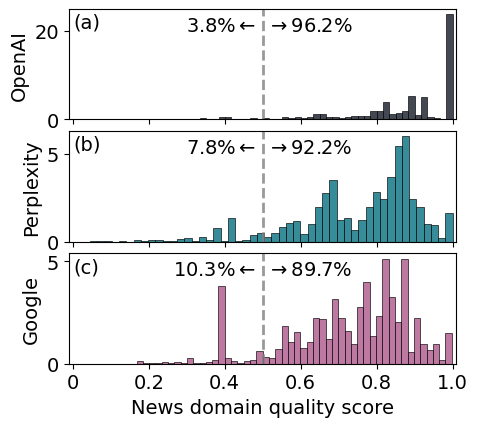

In [10]:
# Create figure with subfigures for quality score distribution by model family
fig = plt.figure(figsize=(5, 4.5))

for i, family in enumerate(providers):
    plt.subplot(3, 1, i + 1)
    # Filter data for this family with non-null quality scores
    family_data = news_citations_df_quality[
        news_citations_df_quality["model_family"] == family
    ]

    # Create histogram
    plt.hist(
        family_data["domain_quality_score"],
        bins=50,
        alpha=0.9,
        color=provider_colors[family],
        edgecolor="black",
        linewidth=0.5,
        density=True,
    )

    # Add vertical line at 0.5
    plt.axvline(x=0.5, color="gray", linestyle="--", linewidth=2, alpha=0.8)
    xs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    if i == 2:
        plt.xlabel("News domain quality score")

        plt.xticks(xs, xs)
    else:
        plt.xticks(xs, [])
    plt.ylabel(provider_names[family])
    plt.xlim([-0.01, 1.01])

    mean_score = family_data["domain_quality_score"].mean()
    median_score = family_data["domain_quality_score"].median()
    n_citations = len(family_data)

    plt.text(
        0.51,
        0.8,
        f"$\\rightarrow${high_quality_pct[family]:.1f}%",
        transform=plt.gca().transAxes,
    )
    plt.text(
        0.482,
        0.8,
        f"{100 - high_quality_pct[family]:.1f}%$\\leftarrow$",
        horizontalalignment='right',
        transform=plt.gca().transAxes,
    )
    plt.text(0.01, 0.83, f"({'abc'[i]})", transform = plt.gca().transAxes)

plt.tight_layout(h_pad=0)
plt.savefig("../../data/output/citation_analysis/model_family_quality_distribution.pdf")